<a href="https://colab.research.google.com/github/Tejas-TA/Face-Mask-Detection-Real-Time-Computer-Vision/blob/main/Mask%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 11
BS = 32

In [3]:
DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
# Grab the list of images in our dataset directory, then initialize the list of data (i.e., images) and class images
print("[INFO] Loading images...")

[INFO] Loading images...


In [5]:
data = []
labels = []

In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [7]:
data

[array([[[-0.4823529 , -0.5529412 , -0.54509807],
         [-0.47450978, -0.54509807, -0.5372549 ],
         [-0.46666664, -0.5372549 , -0.5294118 ],
         ...,
         [ 0.99215686,  0.99215686,  1.        ],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 0.99215686,  0.99215686,  0.99215686]],
 
        [[-0.47450978, -0.54509807, -0.5372549 ],
         [-0.47450978, -0.54509807, -0.5372549 ],
         [-0.46666664, -0.5372549 , -0.5294118 ],
         ...,
         [ 0.99215686,  0.99215686,  1.        ],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 0.99215686,  0.99215686,  0.99215686]],
 
        [[-0.4823529 , -0.5529412 , -0.54509807],
         [-0.4823529 , -0.5529412 , -0.54509807],
         [-0.4823529 , -0.5529412 , -0.54509807],
         ...,
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 0.99215686,  0.99215686,  0.99215686]],
 
        ...,
 
        [[-0.54509807, -0.62352943

In [8]:
labels

['with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with_mask',
 'with

In [9]:
# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [11]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

In [12]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [13]:
# Load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [14]:
# Construct the head of the model that will be placed on top of the the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# Place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# Loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [17]:
# Compile our model
print("[INFO] Compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] Compiling model...


In [18]:
# Train the head of the network
print("[INFO] Training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS) 

[INFO] Training head...
Epoch 1/11
95/95 [==============================] - 171s 2s/step - loss: 0.6254 - accuracy: 0.7088 - val_loss: 0.1914 - val_accuracy: 0.9726
Epoch 2/11
95/95 [==============================] - 164s 2s/step - loss: 0.1790 - accuracy: 0.9660 - val_loss: 0.1051 - val_accuracy: 0.9739
Epoch 3/11
95/95 [==============================] - 165s 2s/step - loss: 0.1012 - accuracy: 0.9786 - val_loss: 0.0798 - val_accuracy: 0.9726
Epoch 4/11
95/95 [==============================] - 165s 2s/step - loss: 0.0831 - accuracy: 0.9812 - val_loss: 0.0742 - val_accuracy: 0.9752
Epoch 5/11
95/95 [==============================] - 165s 2s/step - loss: 0.0800 - accuracy: 0.9811 - val_loss: 0.0663 - val_accuracy: 0.9752
Epoch 6/11
95/95 [==============================] - 164s 2s/step - loss: 0.0683 - accuracy: 0.9785 - val_loss: 0.0675 - val_accuracy: 0.9752
Epoch 7/11
95/95 [==============================] - 163s 2s/step - loss: 0.0593 - accuracy: 0.9812 - val_loss: 0.0587 - val_accura

In [19]:
# Make predictions on the testing set
print("[INFO] Evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] Evaluating network...


In [20]:
# For each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.98       383
without_mask       0.99      0.98      0.98       384

    accuracy                           0.98       767
   macro avg       0.98      0.98      0.98       767
weighted avg       0.98      0.98      0.98       767



In [22]:
print("[INFO] Saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] Saving mask detector model...


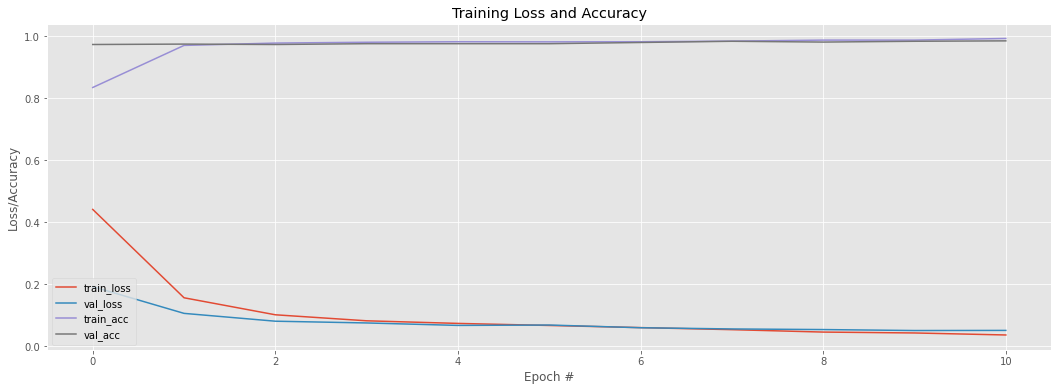

In [23]:
# Plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(18, 6))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")